In [4]:
#input
train_ImagesPart1_dir = 'ImagesPart1'
train_ImagesPart2_dir = 'ImagesPart2'
train_gt_dir = 'train_gt_t13'
test_img_dir = '2017_validation/img'
test_gt_dir = '2017_validation/txt'

In [5]:
import numpy as np
import os
import shutil
from PIL import Image


def seethrough(gt_dir,classes =['Latin','Korean','Chinese','Japanese']):
    '''
    input = classes
    output =  numpy array of shape (10000,num_classes), num_classes = 4
    one image -> [Latin box 갯수, Korean box 갯수, Chinese box 갯수, Japanese box 갯수]
    '''
    textplace = gt_dir
    result = []
    num_classes = len(classes)
    for name in os.listdir(textplace)[0:10000]:
        boxes = [0]*num_classes
        txt = open(textplace+name, mode = 'r', encoding = 'utf-8')
        txt = txt.readlines()
        txt = [a.split(',')[8] for a in txt]
        
        for j in range(len(txt)):
            for i in range(num_classes):
                if txt[j]==classes[i]:
                    boxes[i]+=1
                    
        result.append(boxes)
        
    return np.array(result)

def make_batch_idx(gt_dir,size = 1000,except_list = None):
    
    '''
    output =  size만큼 language ratio를 맞춰 뽑아낸 image의 index들
    
    '''
    random_seed = 42
    num_classes = 4
    lang_ratio = [0.7, 0.1, 0.1, 0.1]
    
    Latin_size = int(size * lang_ratio[0])
    Korean_size = int(size * lang_ratio[1])
    Chinese_size = int(size * lang_ratio[2])
    Japanese_size = size - Latin_size - Korean_size - Chinese_size
    
    gtboxes = seethrough(gt_dir)
    list_ = [[],[],[],[]]
    for i in range(len(gtboxes)):
        for j in range(num_classes):
            if gtboxes[i][j]>0:
                list_[j].append(i)
    Latin_list = list_[0]
    Korean_list = list_[1]
    Chinese_list = list_[2]
    Japanese_list = list_[3]
    
    if except_list:
        picked_set = set(except_list)
    else:        
        picked_set = set()
    
    Latin_list = list(set(Latin_list)-picked_set)
    np.random.seed(random_seed)
    np.random.shuffle(Latin_list)
    Latin_idx = np.array(Latin_list)[np.random.permutation(Latin_size)]
    picked_set = picked_set.union(set(Latin_idx))
    
    Korean_list = list(set(Korean_list)-picked_set)
    np.random.seed(random_seed)
    np.random.shuffle(Korean_list)
    Korean_idx = np.array(Korean_list)[np.random.permutation(Korean_size)]
    picked_set = picked_set.union(set(Korean_idx))
    
    Chinese_list = list(set(Chinese_list)-picked_set)
    np.random.seed(random_seed)
    np.random.shuffle(Chinese_list)
    Chinese_idx = np.array(Chinese_list)[np.random.permutation(Chinese_size)]
    picked_set = picked_set.union(set(Chinese_idx))
    
    Japanese_list = list(set(Japanese_list)-picked_set)
    np.random.seed(random_seed)
    np.random.shuffle(Japanese_list)
    Japanese_idx = np.array(Japanese_list)[np.random.permutation(Japanese_size)]
    picked_set = picked_set.union(set(Japanese_idx))
    Latin_idx.sort()
    Korean_idx.sort()
    Chinese_idx.sort()
    Japanese_idx.sort()
    
    if except_list:
        picked_set = picked_set - set(except_list)
    
    return picked_set,Latin_idx,Korean_idx,Chinese_idx,Japanese_idx

def save_imgs_to_dir(img_dir1,img_dir2,idx_list,directory):
    
    os.makedirs(directory)
    
    name_batch = []
    imageplace = img_dir1
    for name in os.listdir(imageplace):
        name_batch.append(name)
        
    imageplace = img_dir2
    for name in os.listdir(imageplace):
        name_batch.append(name)
    
    for idx in idx_list:
        name = name_batch[idx]
        if idx+1<=5000:
            imageplace = img_dir1
        else:
            imageplace = img_dir2
        
        shutil.copy2(imageplac+'/'+name, directory+'/'+name)
    
def save_txt_to_dir(gt_dir,idx_list, directory):
    os.makedirs(directory)
    
    name_batch = []
    txtplace = gt_dir
    for name in os.listdir(txtplace):
        name_batch.append(name)        
    
    for idx in idx_list:
        name = name_batch[idx]
        shutil.copy2(txtplace+'/'+name, directory+'/'+name)

In [0]:
# train data 2000개와 validation data 200개를 만드는 코드

validation_set,_,_,_,_ = make_batch_idx(train_gt_dir,200)
validation_list = list(validation_set)
validation_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,validation_list,'sample_validation/img')
save_txt_to_dir(train_gt_dir,validation_list,'sample_validation/txt')

train_set,_,_,_,_ = make_batch_idx(train_gt_dir,2000,except_list = validation_list)
train_list = list(train_set)
train_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,train_list,'sample_train/img')
save_txt_to_dir((train_gt_dir,train_list,'sample_train/txt')

In [0]:
# sample data와 error_gif_idx를 제외하고 test data 941개를 만들고 나머지에서 error_gif_idx=54개를 제외한 9005개를 training data로 만드는 코드
error_gif_idx=[101, 164, 1437, 1476, 1673, 2645, 2710, 4191, 4195, 4501, 4555, 5040, 5167, 5305, 5453, 5492, 5535, 5644, 5660, 5736, 5770, 5770, 5770, 5778, 5859, 5865, 5878, 5878, 5997, 6109, 6181, 6206, 6408, 6670, 6788, 6803, 6952, 7030, 7061, 7062, 7073, 7173, 7191, 7216, 7216, 7288, 7429, 7504, 7509, 7513, 7566, 7628, 7643, 7947, 8062, 8295, 8295, 8393, 8845]
except_list = validation_list + train_list + error_gif_idx
test_set,_,_,_,_ = make_batch_idx(train_gt_dir,941,except_list = except_list)
test_list = list(test_set)
test_list.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,test_list,'test/img')
save_txt_to_dir(train_gt_dir,test_list,'test/txt')

other_set = set(list(range(10000)))-test_set
other_set = other_set - set(error_gif_idx)
other_idx = list(other_set)
print(len(other_idx))
other_idx.sort()
save_imgs_to_dir(train_ImagesPart1_dir,train_ImagesPart2_dir,other_idx,'train/img')
save_txt_to_dir(train_gt_dir,other_idx,'train/txt')

9005


In [0]:
import pickle

#train data save as pkl
gt_util = GTUtility(image_path = 'train/img', gt_path = 'train/txt')
file_name = 'ICDAR2019_train.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')

#test data save as pkl
gt_util = GTUtility(image_path = 'test/img', gt_path = 'test/txt')
file_name = 'ICDAR2019_test.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')

#2017 validation data save as pkl
gt_util = GTUtility(image_path = '2017_validation/img', gt_path = '2017_validation/txt')
file_name = 'ICDAR2017_validation.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')


save to ICDAR2019_train.pkl...
done
save to ICDAR2019_test.pkl...
done


In [16]:
#2017 validation data save as pkl
import pickle
gt_util = GTUtility(image_path = '2017_validation/img', gt_path = '2017_validation/txt', val = True)
file_name = 'ICDAR2017_validation.pkl'
print('save to %s...' % file_name)
pickle.dump(gt_util, open(file_name,'wb'))
print('done')


save to ICDAR2017_validation.pkl...
done


In [1]:
# page0
import sys
import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import sys
import os
os.getcwd()

'/content/drive/My Drive/ICDAR_2019/Project_main'

In [0]:
import sys
import os
base_project_directory = '/content/drive/My Drive/ICDAR_2019/Project_main'
sys.path.insert(0, base_project_directory)
os.chdir(base_project_directory)

In [1]:
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model

from utils.layers import Normalize

def TBPP512(input_shape=(512, 512, 3), softmax=True):
    
    x = input_tensor = Input(shape=input_shape)
    source_layers = ssd512_body(x)
    
    num_maps = len(source_layers)
    
    num_priors = [14] * num_maps  # 91
    normalizations = [1] * num_maps
    output_tensor = multibox_head(source_layers, num_priors, normalizations, softmax)
    model = Model(input_tensor, output_tensor)
    
    model.image_size = input_shape[:2]
    model.source_layers = source_layers
    
    model.aspect_ratios = [[1,2,3,5,1/2,1/3,1/5] * 2] * num_maps
    model.shifts = [[(0.0, -0.5)] * 7 + [(0.0, 0.5)] * 7] * num_maps
    model.special_ssd_boxes = False
    model.scale = 0.5
    
    return model

def ssd512_body(x):
    
    source_layers = []
    #수정 한상준4 MaxPool2D => MaxPooling2D
    # Block 1
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_1', activation='relu')(x) #shape : (None, 512, 512, 64)
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_2', activation='relu')(x) #shape : (None, 512, 512, 64)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool1')(x) # shape: (None, 256, 256, 64)
    # Block 2
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_1', activation='relu')(x)
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool2')(x) # shape: (None, 128, 128, 128)
    # Block 3
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_2', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool3')(x) # shape: (None, 64, 64, 256)
    # Block 4
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_3', activation='relu')(x)
    source_layers.append(x) # shape: (None, 64, 64, 512)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool4')(x) # shape: (None, 32, 32, 512)
    # Block 5
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=1, padding='same', name='pool5')(x) # shape: (None, 32, 32, 512)
    # FC6
    x = Conv2D(1024, 3, strides=1, dilation_rate=(6, 6), padding='same', name='fc6', activation='relu')(x) # shape: (None, 32, 32, 1024)
    # FC7
    x = Conv2D(1024, 1, strides=1, padding='same', name='fc7', activation='relu')(x) # shape: (None, 32, 32, 1024)
    source_layers.append(x) # shape: (None, 32, 32, 1024)
    # Block 6
    x = Conv2D(256, 1, strides=1, padding='same', name='conv6_1', activation='relu')(x) # shape: (None, 32, 32, 256)
    x = ZeroPadding2D((1,1))(x) # shape: (None, 33, 33, 256)
    x = Conv2D(512, 3, strides=2, padding='valid', name='conv6_2', activation='relu')(x) # shape: (None, 16, 16, 512)
    source_layers.append(x) # shape: (None, 16, 16, 512)
    # Block 7
    x = Conv2D(128, 1, strides=1, padding='same', name='conv7_1', activation='relu')(x) # shape: (None, 16, 16, 128)
    x = ZeroPadding2D((1,1))(x) # shape: (None, 17, 17, 128)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv7_2', activation='relu')(x) # shape: (None, 8, 8, 256)
    source_layers.append(x) # shape: (None, 8, 8, 256)
    # Block 8
    x = Conv2D(128, 1, strides=1, padding='same', name='conv8_1', activation='relu')(x) # shape: (None, 8, 8, 128)
    x = ZeroPadding2D((1,1))(x) # shape: (None, 9, 9, 128)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv8_2', activation='relu')(x) # shape: (None, 4, 4, 256)
    source_layers.append(x) # shape: (None, 4, 4, 256)
    # Block 9
    x = Conv2D(128, 1, strides=1, padding='same', name='conv9_1', activation='relu')(x) # shape: (None, 4, 4, 128)
    x = ZeroPadding2D((1,1))(x) # shape: (None, 5, 5, 128)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv9_2', activation='relu')(x) # shape: (None, 2, 2, 256)
    source_layers.append(x) # shape: (None, 2, 2, 256)
    # Block 10 
    x = Conv2D(128, 1, strides=1, padding='same', name='conv10_1', activation='relu')(x) # shape: (None, 2, 2, 128)
    x = ZeroPadding2D((1,1))(x) # shape: (None, 3, 3, 128)
    x = Conv2D(256, 4, strides=2, padding='valid', name='conv10_2', activation='relu')(x) # shape: (None, 1, 1, 256)
    source_layers.append(x)  # shape: (None, 1, 1, 256)
    
    return source_layers

def multibox_head(source_layers, num_priors ,normalizations=None , softmax=True):
    
    num_classes = 6
    class_activation = 'softmax' if softmax else 'sigmoid'

    mbox_conf = []
    mbox_loc = []
    mbox_quad = []
    mbox_rbox = []
    for i in range(len(source_layers)):
        x = source_layers[i]             #i=0 => image size of x : (64,64), shape of x : [None, 64, 64, 512]
        name = x.name.split('/')[0]
        
        # normalize
        if normalizations is not None and normalizations[i] > 0:
            name = name + '_norm'
            x = Normalize(normalizations[i], name=name)(x)
            
        # confidence
        name1 = name + '_mbox_conf'
        x1 = Conv2D(num_priors[i] * num_classes, (3, 5), padding='same', name=name1)(x) #num_priors[i]=14, num_classes = 6 => x1 shape : [None, 64, 64, 14*6]
        x1 = Flatten(name=name1+'_flat')(x1) # shape of x1: [batch_size, 64*64*14*6], per class : 64*64*14
        mbox_conf.append(x1)

        # location, Delta(x,y,w,h)
        name2 = name + '_mbox_loc'
        x2 = Conv2D(num_priors[i] * 4, (3, 5), padding='same', name=name2)(x)
        x2 = Flatten(name=name2+'_flat')(x2)
        mbox_loc.append(x2)  # shape of x2: [batch_size, 64*64*14*4]
        
        # quadrilateral, Delta(x1,y1,x2,y2,x3,y3,x4,y4)
        name3 = name + '_mbox_quad'
        x3 = Conv2D(num_priors[i] * 8, (3, 5), padding='same', name=name3)(x)
        x3 = Flatten(name=name3+'_flat')(x3)
        mbox_quad.append(x3) # shape of x3: [batch_size, 64*64*14*8]

        # rotated rectangle, Delta(x1,y1,x2,y2,h)
        name4 = name + '_mbox_rbox'
        x4 = Conv2D(num_priors[i] * 5, (3, 5), padding='same', name=name4)(x)
        x4 = Flatten(name=name4+'_flat')(x4)
        mbox_rbox.append(x4) # shape of x4: [batch_size, 64*64*14*5]
        
    mbox_conf = concatenate(mbox_conf, axis=1, name='mbox_conf')
    mbox_conf = Reshape((-1, num_classes), name='mbox_conf_logits')(mbox_conf) #shape : [batch_size, 64*64*14, 6]
    mbox_conf = Activation(class_activation, name='mbox_conf_final')(mbox_conf)
    
    mbox_loc = concatenate(mbox_loc, axis=1, name='mbox_loc')
    mbox_loc = Reshape((-1, 4), name='mbox_loc_final')(mbox_loc) #shape : [batch_size, 64*64*14, 4]
    
    mbox_quad = concatenate(mbox_quad, axis=1, name='mbox_quad')
    mbox_quad = Reshape((-1, 8), name='mbox_quad_final')(mbox_quad) #shape : [batch_size, 64*64*14, 8]
    
    mbox_rbox = concatenate(mbox_rbox, axis=1, name='mbox_rbox')
    mbox_rbox = Reshape((-1, 5), name='mbox_rbox_final')(mbox_rbox) #shape : [batch_size, 64*64*14, 5]

    predictions = concatenate([mbox_loc, mbox_quad, mbox_rbox, mbox_conf], axis=2, name='predictions')
    
    return predictions # shape : (batch_size,Nums_priors,4+8+5+6) = (batch_size, 76454, 23)

Using TensorFlow backend.


In [2]:


import numpy as np
import matplotlib.pyplot as plt
import cv2 # 수정 한상준4
import random
import os
from thirdparty.get_image_size import get_image_size #수정 한상준2



class GTUtility(object):

    def __init__(self, image_path, gt_path, val = False):
        self.val = val
        self.gt_path = gt_path
        self.image_path = image_path 
        self.classes = ['Background', 'Latin', 'Chinese', 'Korean', 'Japanese', 'Others']
        one_hots = [[1,0,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0,0,0], [0,0,0,1,0,0], [0,0,0,0,1,0], [0,0,0,0,0,1]]
        
        self.image_names = []
        self.data = []

        image_files = sorted(os.listdir(image_path))
        for image_file_name in image_files:
            img_width, img_height = get_image_size(os.path.join(image_path, image_file_name))
            boxes = []
            gt_file_name = os.path.splitext(image_file_name)[0] + '.txt'
            if self.val:
                gt_file_name = 'gt_'+gt_file_name
            
            with open(os.path.join(gt_path, gt_file_name), 'r', encoding='utf-8-sig') as f:
                for line in f:
                    line_split = line.strip().split(',')
                    box = [float(v) for v in line_split[0:8]]
                    
                    classified = False
                    for lang, one_hot in zip(self.classes, one_hots):
                        if line_split[8] == lang:
                            box = box + one_hot
                            classified = True # 수정 박재현2
                    if not classified: #분류가 안된 box들은 'Others' class로 분류한다.
                        box = box + one_hots[5]
                            
                    boxes.append(box)


            boxes = np.asarray(boxes)
            boxes[:,0:8:2] /= img_width
            boxes[:,1:8:2] /= img_height
            self.image_names.append(image_file_name)
            self.data.append(boxes)
            
        self.init() # 수정 한상준2
     
    def init(self):
        self.num_classes = len(self.classes)
        self.classes_lower = [s.lower() for s in self.classes]

        # statistics
        stats = np.zeros(self.num_classes)
        num_without_annotation = 0
        for i in range(len(self.data)):

            if len(self.data[i]) == 0: # box가 없는 image
                num_without_annotation += 1
            else:
                unique, counts = np.unique(np.argmax(self.data[i][:,8:],axis = 1).astype(np.int16), return_counts=True)  # 수정 한상준3
                stats[unique] += counts
        self.stats = stats
        self.num_without_annotation = num_without_annotation
        
        self.num_samples = len(self.image_names)
        self.num_images = len(self.data)
        self.num_objects = sum(self.stats)
   
    def sample(self, idx=None): #수정 한상준9
        '''Draw a random sample form the dataset.
        '''
        if idx is None:
            idx = np.random.randint(0, len(self.image_names))
        file_path = os.path.join(self.image_path, self.image_names[idx])
        img = cv2.imread(file_path)

        img = img[:, :, (2,1,0)] # BGR to RGB
        img = img / 255.
        return idx, img, self.data[idx]
    
    def sample_random_batch(self, batch_size=32, input_size=(512,512), seed=1337): #수정 한상준9
        
        h, w = input_size
        aspect_ratio = w/h
        if seed is not None:
            np.random.seed(seed)
        idxs = np.arange(self.num_samples)
        np.random.shuffle(idxs)
        idxs = idxs[:batch_size] #수정 한상준10
        
        inputs = []
        images = []
        data = []
        
        for i in idxs:
            
            img_path = os.path.join(self.image_path, self.image_names[i])
            img = cv2.imread(img_path)
            
            gt = self.data[i]
            
            inputs.append(preprocess(img, input_size))
            img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32') # should we do resizing
            img = img[:, :, (2,1,0)] # BGR to RGB
            img /= 255
            images.append(img)
            data.append(gt)
        inputs = np.asarray(inputs)

        return idxs, inputs, images, data
    
    def sample_batch(self, batch_size, batch_index, input_size=(512,512)):#수정 한상준9
        h, w = input_size
        aspect_ratio = w/h
        idxs = np.arange(min(batch_size*batch_index, self.num_samples), 
                         min(batch_size*(batch_index+1), self.num_samples))
        
        if len(idxs) == 0:
            print('WARNING: empty batch')
        
        inputs = []
        data = []
        for i in idxs:
            img_path = os.path.join(self.image_path, self.image_names[i])
            img = cv2.imread(img_path)
#             if preserve_aspect_ratio:
#                 img = pad_image(img, aspect_ratio) #수정 한상준9
            inputs.append(preprocess(img, input_size))
            data.append(self.data[i])
        inputs = np.asarray(inputs)
        
        return inputs, data
    
        
def preprocess(img, size): #수정 한상준3
    """Precprocess an image for ImageNet models.
    
    # Arguments
        img: Input Image
        size: Target image size (height, width).
    
    # Return
        Resized and mean subtracted BGR image, if input was also BGR.
    """
    h, w = size
    img = np.copy(img)
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR)
    img = img.astype(np.float32)
    mean = np.array([104,117,123])
    img -= mean[np.newaxis, np.newaxis, :] 
    return img


In [3]:
# page3

from utils.bboxes import polygon_to_rbox3
from utils.vis import to_rec

def iou(box, priors):
    
    # compute intersection
    inter_upleft = np.maximum(priors[:, :2], box[:2])
    inter_botright = np.minimum(priors[:, 2:4], box[2:])
    inter_wh = inter_botright - inter_upleft
    inter_wh = np.maximum(inter_wh, 0)
    inter = inter_wh[:, 0] * inter_wh[:, 1]
    # compute union
    area_pred = (box[2] - box[0]) * (box[3] - box[1])
    area_gt = (priors[:, 2] - priors[:, 0]) * (priors[:, 3] - priors[:, 1])
    union = area_pred + area_gt - inter
    # compute iou
    iou = inter / union
    
    return iou  #수정 한상준2

def non_maximum_suppression_slow(boxes, confs, iou_threshold, top_k):
    """Does None-Maximum Suppresion on detection results.
    
    Intuitive but slow as hell!!!
    
    # Agruments
        boxes: Array of bounding boxes (boxes, xmin + ymin + xmax + ymax).
        confs: Array of corresponding confidenc values.
        iou_threshold: Intersection over union threshold used for comparing 
            overlapping boxes.
        top_k: Maximum number of returned indices.
    
    # Return
        List of remaining indices.
    """
    idxs = np.argsort(-confs)
    selected = []
    for idx in idxs:
        if np.any(iou(boxes[idx], boxes[selected]) >= iou_threshold):
            continue
        selected.append(idx)
        if len(selected) >= top_k:
            break
    return selected #수정 박재현3

def non_maximum_suppression(boxes, confs, overlap_threshold, top_k):
    """Does None-Maximum Suppresion on detection results.
    
    # Agruments
        boxes: Array of bounding boxes (boxes, xmin + ymin + xmax + ymax).
        confs: Array of corresponding confidenc values.
        overlap_threshold: 
        top_k: Maximum number of returned indices.
    
    # Return
        List of remaining indices.
    
    # References
        - Girshick, R. B. and Felzenszwalb, P. F. and McAllester, D.
          [Discriminatively Trained Deformable Part Models, Release 5](http://people.cs.uchicago.edu/~rbg/latent-release5/)
    """
    eps = 1e-15
    
    boxes = boxes.astype(np.float64)

    pick = []
    x1, y1, x2, y2 = boxes.T
    
    idxs = np.argsort(confs)
    area = (x2 - x1) * (y2 - y1)
    
    while len(idxs) > 0:
        i = idxs[-1]
        
        pick.append(i)
        if len(pick) >= top_k:
            break
        
        idxs = idxs[:-1]
        
        xx1 = np.maximum(x1[i], x1[idxs])
        yy1 = np.maximum(y1[i], y1[idxs])
        xx2 = np.minimum(x2[i], x2[idxs])
        yy2 = np.minimum(y2[i], y2[idxs])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        I = w * h 
        
        overlap = I / (area[idxs] + eps)
        # as in Girshick et. al.
        
        #U = area[idxs] + area[i] - I
        #overlap = I / (U + eps)
        
        idxs = idxs[overlap <= overlap_threshold]
        
    return pick #수정 박재현3
  

def non_max_suppression_class(input_boxes,iou_threshold = 0.5): #수정 한상준8
    '''
    서로 다른 class에 있는 box끼리도 iou threshold 0.5로 겹치는거 제외하기
    input_boxes = boxes with [bbox, quad, r_box, max_confidence, class],
                box들의 max_confidence가 큰 순서대로 배열된 numpy array
    '''
    bboxes= input_boxes[:,:4]
    i=0
    
    
    while i<len(bboxes)-1:
        mask = np.array([True]*len(bboxes))
        
        mask[i+1:] = iou(bboxes[i], bboxes[i+1:])<0.5
        bboxes = bboxes[mask]
        input_boxes = input_boxes[mask]
        i+=1
    return input_boxes
  
class PriorUtil(object):
    
    def __init__(self, model, aspect_ratios=None, shifts=None,
            minmax_sizes=None, steps=None, scale=None, clips=None, 
            special_ssd_boxes=None, ssd_assignment=None):
        
        
        source_layers_names = [l.name.split('/')[0] for l in model.source_layers]
        self.source_layers_names = source_layers_names
        
        self.model = model
        self.image_size = model.input_shape[1:3]
        
        num_maps = len(source_layers_names)
        
        aspect_ratios = model.aspect_ratios #수정 한상준1
        shifts = model.shifts #수정 한상준1
        
        if minmax_sizes is None:
            if hasattr(model, 'minmax_sizes'):
                minmax_sizes = model.minmax_sizes
            else:
                # as in equation (4)
                min_dim = np.min(self.image_size)
                min_ratio = 10 # 15
                max_ratio = 100 # 90
                s = np.linspace(min_ratio, max_ratio, num_maps+1) * min_dim / 100.
                minmax_sizes = [(round(s[i]), round(s[i+1])) for i in range(len(s)-1)]

        scale = model.scale #수정 한상준1      
        minmax_sizes = np.array(minmax_sizes) * scale
        
        steps = [None] * num_maps #수정 한상준1
        
        clips = True #수정 한상준2
        clips = [clips] * num_maps #수정 한상준1
        
        special_ssd_boxes = False
        special_ssd_boxes = [special_ssd_boxes] * num_maps #수정 한상준1
        
        ssd_assignment = True #수정 한상준1
        self.ssd_assignment = ssd_assignment
        
        self.prior_maps = []
        for i in range(num_maps):
            layer = model.get_layer(source_layers_names[i])
            map_h, map_w = map_size = layer.output_shape[1:3]
            m = PriorMap(source_layer_name=source_layers_names[i],
                         image_size=self.image_size,
                         map_size=map_size,
                         minmax_size=minmax_sizes[i],
                         variances=[0.1, 0.1, 0.2, 0.2],
                         aspect_ratios=aspect_ratios[i],
                         shift=shifts[i],
                         step=steps[i],
                         special_ssd_box=special_ssd_boxes[i],
                         clip=clips[i])
            self.prior_maps.append(m)
        self.update_priors()

        self.nms_top_k = 400
        self.nms_thresh = 0.45 #수정 박재현3
    
    def update_priors(self):
        priors_xy = []
        priors_wh = []
        priors_min_xy = []
        priors_max_xy = []
        priors_variances = []
        priors = []
        
        map_offsets = [0]
        
        # 모든 층에서 정의되는 prior map들에 대한 정보를 위에서 정의한 list들에 하나하나 append를 시킨다
        for i in range(len(self.prior_maps)): 
            m = self.prior_maps[i]
            
            # compute prior boxes
            m.compute_priors()
            
            # collect prior data
            priors_xy.append(m.priors_xy)
            priors_wh.append(m.priors_wh)
            priors_min_xy.append(m.priors_min_xy)
            priors_max_xy.append(m.priors_max_xy)
            priors_variances.append(m.priors_variances)
            priors.append(m.priors)
            map_offsets.append(map_offsets[-1]+len(m.priors))
        
        # append시킨 list를 axis=0에 대하여 concatenate시켜서 length가 모든 층의 prior map의 갯수를 전부 더한것 만큼 된다.
        self.priors_xy = np.concatenate(priors_xy, axis=0)
        self.priors_wh = np.concatenate(priors_wh, axis=0)
        self.priors_min_xy = np.concatenate(priors_min_xy, axis=0)
        self.priors_max_xy = np.concatenate(priors_max_xy, axis=0)
        self.priors_variances = np.concatenate(priors_variances, axis=0)
        self.priors = np.concatenate(priors, axis=0)
        self.map_offsets = map_offsets
        
        # normalized prior boxes (마지막으로 prior box coordinate과 여러 정보들을 image size로 나누어서 normalize시킨다.)
        image_h, image_w = self.image_size
        self.priors_xy_norm = self.priors_xy / (image_w, image_h)
        self.priors_wh_norm = self.priors_wh / (image_w, image_h)
        self.priors_min_xy_norm = self.priors_min_xy / (image_w, image_h)
        self.priors_max_xy_norm = self.priors_max_xy / (image_w, image_h)
        self.priors_norm = np.concatenate([self.priors_min_xy_norm, self.priors_max_xy_norm, self.priors_variances], axis=1)
    
    
    def encode(self, gt_data, overlap_threshold=0.5, debug=False):
        
        '''
        
        gt_data의 예시:
        image 하나당 [x1,y1, x2,y2, x3,y3, x4,y4, 6_one_hot_class]의 데이터가 box갯수만큼 있음
        
        [[0.56833333 0.20300752 0.97666667 0.33333333 0.97       0.47619048
          0.55833333 0.34586466 0.         0.         0.         0.
          0.         1.        ]
         [0.11666667 0.45864662 0.14166667 0.45614035 0.14       0.49874687
          0.115      0.50125313 0.         1.         0.         0.
          0.         0.        ]
         [0.88333333 0.47869674 0.91166667 0.48120301 0.91       0.50626566
          0.88166667 0.5037594  0.         1.         0.         0.
          0.         0.        ]
         [0.03166667 0.30075188 0.42666667 0.160401   0.44666667 0.30075188
          0.03666667 0.46867168 0.         1.         0.         0.
          0.         0.        ]
         [0.15833333 0.39598997 0.42       0.40601504 0.415      0.48120301
          0.15333333 0.47368421 0.         1.         0.         0.
          0.         0.        ]
         [0.58166667 0.41854637 0.85833333 0.4235589  0.86       0.4962406
          0.58166667 0.49373434 0.         1.         0.         0.
          0.         0.        ]
         [0.63       0.57894737 0.68333333 0.60150376 0.67666667 0.64160401
          0.62333333 0.61904762 0.         1.         0.         0.
          0.         0.        ]
         [0.46       0.71428571 0.555      0.71428571 0.555      0.74937343
          0.46       0.74937343 0.         0.         0.         0.
          0.         1.        ]]
          
          위에서 정의한 prior box들의 정보를 가지고 prior box와 gt_data를 match시켜서 
          shape = [priormap갯수(엄청큼), 4+8+5+confidence_of_class] 인 넘파이배열을 return한다.
          confidence class에서는 4+8+5의 정보가 gt_data와의 iou가 0.5를 넘는게 없다면 background class로 분류된다.
          
        ''' 
        
        '''
        array([[0.09446537, 0.64231986, 0.6947241 , 0.80873207, 0.66108891,
        1.05911375, 0.05824286, 0.92018245, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ]]) error찾기
        '''
        # image에 box가 없을경우
        if gt_data.shape[0] == 0:
            print('gt_data', type(gt_data), gt_data.shape)
        eps = 1e-15 #수정 한상준13
        num_classes = 6
        num_priors = self.priors.shape[0]
        
        gt_polygons = np.copy(gt_data[:,:8]) # normalized quadrilaterals
        gt_rboxes = np.array([polygon_to_rbox3(np.reshape(p, (-1,2))) for p in gt_data[:,:8]])
        
        # minimum horizontal bounding rectangles
        gt_xmin = np.min(gt_data[:,0:8:2], axis=1) #shape : [nb_boxes]
        gt_ymin = np.min(gt_data[:,1:8:2], axis=1)
        gt_xmax = np.max(gt_data[:,0:8:2], axis=1)
        gt_ymax = np.max(gt_data[:,1:8:2], axis=1)
        
        gt_boxes = self.gt_boxes = np.array([gt_xmin,gt_ymin,gt_xmax,gt_ymax]).T # shape : [nb_boxes, 4]
                                                                                 # normalized xmin, ymin, xmax, ymax
        gt_one_hot = gt_data[:,8:] # shape : [nb_boxes, 6]

        gt_iou = np.array([iou(b, self.priors_norm) for b in gt_boxes]).T 
        # shape of self.priors_norm : [Nums_priors, min_xy + max_xy+ variance]
        # b = [4], self.priors_norm = [Nums_priors, 4+4]
        # shape of gt_iou : [[Nums_priors] for b in gt_boxes].transpose = [nb_boxes, Nums_priors].transpose = [Num_priors, nb_boxes]
        
        # assigne gt to priors
        max_idxs = np.argmax(gt_iou, axis=1) # shape : [Num_priors]
        max_val = gt_iou[np.arange(num_priors), max_idxs] # shape: [Num_priors]
        prior_mask = max_val > overlap_threshold #IOU값의 maximum이 0.5가 넘는 prior들만 True값을 줌 
        match_indices = max_idxs[prior_mask] # shape : [Num_priors - False_priors]

        self.match_indices = dict(zip(list(np.ix_(prior_mask)[0]), list(match_indices))) 
        # {prior_1 : max_idx, prior_3 : max_idx, prior_4 : max_idx, prior_7 : max_idx, ...}
        
        # prior labels
        confidence = np.zeros((num_priors, num_classes))
        confidence[:,0] = 1  # 일단 모든 prior들을 background 로 정의
        confidence[prior_mask] = gt_one_hot[match_indices]  # mask가 True인것(iou>0.5)만 one_hot_class를 새로 매겨줌

        gt_xy = (gt_boxes[:,2:4] + gt_boxes[:,0:2]) / 2.  #shape : [nb_boxes,2]
        gt_wh = gt_boxes[:,2:4] - gt_boxes[:,0:2]    #shape : [nb_boxes,2]
        gt_xy = gt_xy[match_indices]    #shape : [True_priors,2] , True_priors = Num_priors - False_priors
        gt_wh = gt_wh[match_indices]    #shape : [True_priors,2]

        gt_polygons = gt_polygons[match_indices]  #shape : [True_priors,8]
        gt_rboxes = gt_rboxes[match_indices]  #shape : [True_priors,5]
        
        priors_xy = self.priors_xy[prior_mask] / self.image_size  # = self.priors_xy_norm[prior_mask]
        priors_wh = self.priors_wh[prior_mask] / self.image_size  # = self.priors_wh_norm[prior_mask]
        variances_xy = self.priors_variances[prior_mask,0:2]
        variances_wh = self.priors_variances[prior_mask,2:4]
        
        # compute local offsets for 
        # gt_x = prior_x + prior_w * x_label
        # x_label = x_label / 0.1
        # gt_w = exp(w_label) * prior_w
        # w_label = w_label / 0.2
        offsets = np.zeros((num_priors, 4))
        offsets[prior_mask,0:2] = (gt_xy - priors_xy) / priors_wh
        offsets[prior_mask,2:4] = np.log(gt_wh / priors_wh )#수정 한상준13
        offsets[prior_mask,0:2] /= variances_xy
        offsets[prior_mask,2:4] /= variances_wh
        
        # compute local offsets for quadrilaterals
        # gt_x1 = prior_x1 + prior_w * x1_label 
        # x1_label = x1_label / 0.1
        offsets_quads = np.zeros((num_priors, 8))
        priors_xy_minmax = np.hstack([priors_xy-priors_wh/2, priors_xy+priors_wh/2])
        ref = priors_xy_minmax[:,(0,1,2,1,2,3,0,3)] # corner points
        offsets_quads[prior_mask,:] = (gt_polygons - ref) / np.tile(priors_wh, (1,4)) / np.tile(variances_xy, (1,4))
        
        # compute local offsets for rotated bounding boxes
        # gt_x1 = prior_x1 + prior_w * x1_label
        # x1_label = x1_label / 0.1
        # gt_h = exp(h_label) * prior_h
        # h_label = h_label / 0.2
        offsets_rboxs = np.zeros((num_priors, 5))
        offsets_rboxs[prior_mask,0:2] = (gt_rboxes[:,0:2] - priors_xy) / priors_wh / variances_xy
        offsets_rboxs[prior_mask,2:4] = (gt_rboxes[:,2:4] - priors_xy) / priors_wh / variances_xy
        offsets_rboxs[prior_mask,4] = np.log(gt_rboxes[:,4] / priors_wh[:,1] ) / variances_wh[:,1] #수정 한상준13
        
        return np.concatenate([offsets, offsets_quads, offsets_rboxs, confidence], axis=1)
      
      
    def decode(self, model_output, confidence_threshold=0.01, keep_top_k=200, fast_nms=False, sparse=True):
        # calculation is done with normalized sizes
        # mbox_loc, mbox_quad, mbox_rbox, mbox_conf
        # 4,8,5,2
        # boxes, quad, rboxes, confs, labels
        # 4,8,5,1,1
        
#        print("decode debugging")
#        print(model_output[:500, :])
        
        prior_mask = model_output[:,17:] > confidence_threshold
        
        if sparse:
            # compute boxes only if the confidence is high enough and the class is not background
            mask = np.any(prior_mask[:,1:], axis=1)
            prior_mask = prior_mask[mask]
            mask = np.ix_(mask)[0]
            model_output = model_output[mask]
            priors_xy = self.priors_xy[mask] / self.image_size
            priors_wh = self.priors_wh[mask] / self.image_size
            priors_variances = self.priors_variances[mask,:]
        else:
            priors_xy = self.priors_xy / self.image_size
            priors_wh = self.priors_wh / self.image_size
            priors_variances = self.priors_variances
            
        #print('offsets', len(confidence), len(prior_mask))
        
        offsets = model_output[:,:4]
        offsets_quads = model_output[:,4:12]
        offsets_rboxs = model_output[:,12:17]
        confidence = model_output[:,17:]
        
        priors_xy_minmax = np.hstack([priors_xy-priors_wh/2, priors_xy+priors_wh/2])
        ref = priors_xy_minmax[:,(0,1,2,1,2,3,0,3)] # corner points
        variances_xy = priors_variances[:,0:2]
        variances_wh = priors_variances[:,2:4]
        
        num_priors = offsets.shape[0]
        num_classes = confidence.shape[1]

        # compute bounding boxes from local offsets
        boxes = np.empty((num_priors, 4))
        offsets = offsets * priors_variances
        boxes_xy = priors_xy + offsets[:,0:2] * priors_wh
        boxes_wh = priors_wh * np.exp(offsets[:,2:4])
        boxes[:,0:2] = boxes_xy - boxes_wh / 2. # xmin, ymin
        boxes[:,2:4] = boxes_xy + boxes_wh / 2. # xmax, ymax
        boxes = np.clip(boxes, 0.0, 1.0)
        
        # do non maximum suppression
        results = []
        for c in range(1, num_classes):
            mask = prior_mask[:,c]
            boxes_to_process = boxes[mask]
            if len(boxes_to_process) > 0:
                confs_to_process = confidence[mask, c]
                #print(len(confs_to_process))
                
                # Tensorflow NMS
                #feed_dict = {
                #self.boxes: boxes_to_process,
                #    self.scores: confs_to_process
                #}
                #idx = self.sess.run(self.nms, feed_dict=feed_dict)
                
                if fast_nms:
                    idx = non_maximum_suppression(
                            boxes_to_process[:,:4], confs_to_process, 
                            self.nms_thresh, self.nms_top_k)
                else:
                    idx = non_maximum_suppression_slow(
                            boxes_to_process[:,:4], confs_to_process, 
                            self.nms_thresh, self.nms_top_k)
                
                good_boxes = boxes_to_process[idx]
                good_confs = confs_to_process[idx][:, None]
                labels = np.ones((len(idx),1)) * c
                
                good_quads = ref[mask][idx] + offsets_quads[mask][idx] * np.tile(priors_wh[mask][idx], (1,4)) * np.tile(variances_xy[mask][idx], (1,4))

                good_rboxs = offsets_rboxs[mask][idx]
                
                good_rboxs = np.empty((len(idx), 5))
                good_rboxs[:,0:2] = priors_xy[mask][idx] + offsets_rboxs[mask][idx,0:2] * priors_wh[mask][idx] * variances_xy[mask][idx]
                good_rboxs[:,2:4] = priors_xy[mask][idx] + offsets_rboxs[mask][idx,2:4] * priors_wh[mask][idx] * variances_xy[mask][idx]
                good_rboxs[:,4] = np.exp(offsets_rboxs[mask][idx,4] * variances_wh[mask][idx,1]) * priors_wh[mask][idx,1]
                
                c_pred = np.concatenate((good_boxes, good_quads, good_rboxs, good_confs, labels), axis=1)
               
                results.extend(c_pred)
        if len(results) > 0:
            results = np.array(results)
            order = np.argsort(-results[:, 17])
            results = results[order]
            results = results[:keep_top_k]
            #class끼리도 IOU threshold 0.5로 없애기
            results = non_max_suppression_class(results,iou_threshold = 0.5) #수정 한상준8
        else:
            results = np.empty((0,19))#수정 한상준9
        self.results = results
        return results    #수정 박재현3

    def plot_results(self, results=None, classes=None, show_labels=True, gt_data=None, confidence_threshold=None):
        if results is None:
            results = self.results
        if confidence_threshold is not None:
            mask = results[:, 4] > confidence_threshold
            results = results[mask]
        if classes is not None:
            colors = plt.cm.hsv(np.linspace(0, 1, len(classes)+1)).tolist()
        ax = plt.gca()
        im = plt.gci()
        image_size = im.get_size()
        
        # draw ground truth
        if gt_data is not None:
            for box in gt_data:
                label = np.nonzero(box[4:])[0][0]+1
                color = 'g' if classes == None else colors[label]
                xy_rec = to_rec(box[:4], image_size)
                ax.add_patch(plt.Polygon(xy_rec, fill=True, color=color, linewidth=1, alpha=0.3))
        
        # draw prediction
        for r in results:

#             confidence = 0
#             label = 0
#             cnt = 0
#             for con in r[17:]:
#                 if confidence < con:
#                     confidence = con
#                     label = cnt
#                 cnt += 1
            label = int(r[18])
            confidence = r[17]

            color = 'r' if classes == None else colors[label]
            xy_rec = to_rec(r[:4], image_size)
            ax.add_patch(plt.Polygon(xy_rec, fill=False, edgecolor=color, linewidth=2))
            if show_labels:
                label_name = label if classes == None else classes[label]
                xmin, ymin = xy_rec[0]
                display_txt = '%0.2f, %s' % (confidence, label_name)        
                ax.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5}) #수정 박재현4

class PriorMap(object):
    
    def __init__(self, source_layer_name, image_size, map_size, 
                 minmax_size=None, variances=[0.1, 0.1, 0.2, 0.2], 
                 aspect_ratios=[1], shift=None,
                 clip=False, step=None, special_ssd_box=False):
        self.__dict__.update(locals())  #수정 한상준3
#         self.compute_priors()

    def compute_priors(self):
        image_h, image_w = image_size = self.image_size
        map_h, map_w = map_size = self.map_size
        min_size, max_size = self.minmax_size
        # map_size = [(64,64),(32,32),(16,16),(8,8),(4,4),(2,2),(1,1)]
        
        # define centers of prior boxes
        if self.step is None:
            step_x = round(image_w / map_w)
            step_y = round(image_h / map_h)
        else:
            step_x = step_y = self.step
        # step_x, step_y = [(8,8), (16,16), (32,32), (64,64), (128,128), (256,256), (512,512)]
            
        linx = np.array([(0.5 + i) for i in range(map_w)]) * step_x
        liny = np.array([(0.5 + i) for i in range(map_h)]) * step_y
        box_xy = np.array(np.meshgrid(linx, liny)).reshape(2,-1).T
        
        if self.shift is None:
            shift = [(0.0,0.0)] * len(self.aspect_ratios)
        else:
            shift = self.shift
        
        box_wh = []
        box_shift = []
        for i in range(len(self.aspect_ratios)):
            ar = self.aspect_ratios[i]
            box_wh.append([min_size * np.sqrt(ar), min_size / np.sqrt(ar)])
            box_shift.append(shift[i])
            
        box_wh = np.asarray(box_wh)
        
        box_shift = np.asarray(box_shift)
        box_shift = np.clip(box_shift, -1.0, 1.0)
        box_shift = box_shift * 0.5 * np.array([step_x, step_y]) # percent to pixels
        
        # values for individual prior boxes
        priors_shift = np.tile(box_shift, (len(box_xy),1))
        priors_xy = np.repeat(box_xy, len(box_wh), axis=0) + priors_shift
        priors_wh = np.tile(box_wh, (len(box_xy),1))
                
        priors_min_xy = priors_xy - priors_wh / 2.
        priors_max_xy = priors_xy + priors_wh / 2.
        
        if self.clip: #수정 한상준2 들여쓰기오류
            priors_min_xy[:,0] = np.clip(priors_min_xy[:,0], 0, image_w)
            priors_min_xy[:,1] = np.clip(priors_min_xy[:,1], 0, image_h)
            priors_max_xy[:,0] = np.clip(priors_max_xy[:,0], 0, image_w)
            priors_max_xy[:,1] = np.clip(priors_max_xy[:,1], 0, image_h)
        
        priors_variances = np.tile(self.variances, (len(priors_xy),1))
        
        self.box_xy = box_xy
        self.box_wh = box_wh
        self.box_shfit = box_shift
        
        self.priors_xy = priors_xy
        self.priors_wh = priors_wh
        self.priors_min_xy = priors_min_xy
        self.priors_max_xy = priors_max_xy
        self.priors_variances = priors_variances
        self.priors = np.concatenate([priors_min_xy, priors_max_xy, priors_variances], axis=1)

In [4]:
# page4

class InputGenerator(object):
    """Model input generator for data augmentation."""
    # TODO
    # flag to protect bounding boxes from cropping?
    # padding to preserve aspect ratio? crop_area_range=[0.75, 1.25]
    
    def __init__(self, gt_util, prior_util, batch_size, input_size,
                preserve_aspect_ratio=True,
                augmentation=True, # 수정 한상준3
                saturation_var=0.5,
                brightness_var=0.5,
                contrast_var=0.5,
                lighting_std=0.5,
                hflip_prob=0.5,
                vflip_prob=0.5,
                do_crop=True,
                add_noise=False,
                crop_area_range=[0.75, 1.0],
                aspect_ratio_range=[4./3., 3./4.]):
        
        self.__dict__.update(locals()) 
        
        
        self.num_batches = gt_util.num_samples // batch_size
    
    def random_sized_crop(self, img, target):
        img_h, img_w = img.shape[:2]
        
        # make sure that we can preserve the aspect ratio
        ratio_range = self.aspect_ratio_range
        random_ratio = ratio_range[0] + np.random.random() * (ratio_range[1] - ratio_range[0])
        # a = w/h, w_i-w >= 0, h_i-h >= 0 leads to LP: max. h s.t. h <= w_i/a, h <= h_i
        max_h = min(img_w/random_ratio, img_h)
        max_w = max_h * random_ratio
        
        # scale the area
        crop_range = self.crop_area_range
        random_scale = crop_range[0] + np.random.random() * (crop_range[1] - crop_range[0])
        target_area = random_scale * max_w * max_h
        w = np.round(np.sqrt(target_area * random_ratio))
        h = np.round(np.sqrt(target_area / random_ratio))
        x = np.random.random() * (img_w - w)
        y = np.random.random() * (img_h - h)
        
        w_rel = w / img_w
        h_rel = h / img_h
        x_rel = x / img_w
        y_rel = y / img_h
        
        w, h, x, y = int(w), int(h), int(x), int(y)
        
        # crop image and transform boxes
        new_img = img[y:y+h, x:x+w]
        num_coords = 8  # 우리의 경우는 polynomial case 수정 한상준3
        new_target = []
        if num_coords == 8: # polynom case
            for box in target:
                
                new_box = np.copy(box)
                new_box[0:8:2] -= x_rel
               
                new_box[0:8:2] /= w_rel
                
                new_box[1:8:2] -= y_rel
                
                new_box[1:8:2] /= h_rel
                

                
                if (new_box[0] < 1 and new_box[6] < 1 and new_box[2] > 0 and new_box[4] > 0 and 
                    new_box[1] < 1 and new_box[3] < 1 and new_box[5] > 0 and new_box[7] > 0):
                    
                    new_target.append(new_box)
            new_target = np.asarray(new_target)

            new_target = np.asarray(new_target).reshape(-1, target.shape[1]) # target.shape[1] = 8+num_classes = 14

        return new_img, new_target
    
    def generate(self, debug=False, encode=True, seed=None):#수정 한상준10
        h, w = self.input_size #(512, 512)
        mean = np.array([104,117,123])
        gt_util = self.gt_util
        batch_size = self.batch_size
        num_batches = self.num_batches
        aspect_ratio = w/h # 1
        
        if seed is not None:
            np.random.seed(seed)
        
        inputs, targets = [], []
        
        while True:
            idxs = np.arange(gt_util.num_samples)
            np.random.shuffle(idxs)
            idxs = idxs[:num_batches*batch_size]
            
            for j, i in enumerate(idxs):                          
                img_name = gt_util.image_names[i]
                
                img_path = os.path.join(gt_util.image_path, img_name)
                img = cv2.imread(img_path)
                y = np.copy(gt_util.data[i])

                if self.augmentation:
                    if self.do_crop:
                        for _ in range(10): # tries to crop without losing ground truth
                            img_tmp, y_tmp = self.random_sized_crop(img, y)
                            if len(y_tmp) > 0:
                                break
                        if len(y_tmp) > 0:
                            img = img_tmp
                            y = y_tmp
                    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR)
                    img = img.astype(np.float32)

                    
                else:
                    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR)
                    img = img.astype(np.float32)

                img -= mean[np.newaxis, np.newaxis, :] 
                
                
                inputs.append(img)
                targets.append(y)
                
                
                #if len(targets) == batch_size or j == len(idxs)-1: # last batch in epoch can be smaller then batch_size
                if len(targets) == batch_size:
                    if encode:
                        targets = [self.prior_util.encode(y) for y in targets]
                        targets = np.array(targets, dtype=np.float32)
                    tmp_inputs = np.array(inputs, dtype=np.float32)
                    tmp_targets = targets
                    inputs, targets = [], []
                    yield tmp_inputs, tmp_targets
                    
                    
                elif j == len(idxs)-1:
                    # forgett last batch
                    inputs, targets = [], []
                    break
                    
            print('NEW epoch')
        print('EXIT generator')

In [5]:
# page5

import tensorflow as tf
import keras.backend as K

def smooth_l1_loss(y_true, y_pred):
    
    abs_loss = tf.abs(y_true - y_pred)
    sq_loss = 0.5 * (y_true - y_pred)**2
    loss = tf.where(tf.less(abs_loss, 1.0), sq_loss, abs_loss - 0.5)
    return tf.reduce_sum(loss, axis=-1)

def focal_loss(y_true, y_pred, gamma=2., alpha=1.):
    

    eps = K.epsilon()
    y_pred = K.clip(y_pred, 1e-7, 1- 1e-7)
    pt = tf.where(tf.equal(y_true, 1.), y_pred, 1.-y_pred)
    loss = - K.pow(1.-pt, gamma) * K.log(pt)   #수정 한상준10
    loss = alpha * loss
    

    return tf.reduce_sum(loss, axis=-1)


class TBPPFocalLoss(object):

    def __init__(self, lambda_conf=1000.0, lambda_offsets=0.1):
        self.lambda_conf = lambda_conf
        self.lambda_offsets = lambda_offsets
        self.metrics = []
    
    def compute(self, y_true, y_pred):
        # y.shape (batches, priors, 4 x bbox_offset + 8 x quadrilaterals + 5 x rbbox_offsets + n x class_label)
        
        
        batch_size = tf.shape(y_true)[0]
        num_priors = tf.shape(y_true)[1]
        num_classes = tf.shape(y_true)[2] - 17
        eps = K.epsilon() #keras.backend.epsilon() 1e-07
        
        # confidence loss
        conf_true = tf.reshape(y_true[:,:,17:], [-1, num_classes])
        conf_pred = tf.reshape(y_pred[:,:,17:], [-1, num_classes])
        
        class_true = tf.argmax(conf_true, axis=1) # shape = [batch_size*76454]
        class_pred = tf.argmax(conf_pred, axis=1) # shape = [batch_size*76454]
        conf = tf.reduce_max(conf_pred, axis=1) # shape = [batch_size*76454]
        
        neg_mask_float = conf_true[:,0] # background box들을 mask함
        neg_mask = tf.cast(neg_mask_float, tf.bool) # 1 => True, 0 => False
        pos_mask = tf.logical_not(neg_mask) #True => False, False => True
        pos_mask_float = tf.cast(pos_mask, tf.float32) #True => 1, False => 0
        num_total = tf.cast(tf.shape(conf_true)[0], tf.float32)
        num_pos = tf.reduce_sum(pos_mask_float)
        num_neg = num_total - num_pos
        
        conf_loss = focal_loss(conf_true, conf_pred) # 수정 한상준5 alpha삭제
        conf_loss = tf.reduce_sum(conf_loss)
        
        conf_loss = conf_loss / (num_total + eps)
        
        # offset loss, bbox, quadrilaterals, rbbox
        loc_true = tf.reshape(y_true[:,:,0:17], [-1, 17])
        loc_pred = tf.reshape(y_pred[:,:,0:17], [-1, 17])
        
        loc_loss = smooth_l1_loss(loc_true, loc_pred)
        #loc_loss = smooth_l1_loss(loc_true[:,:4], loc_pred[:,:4])
        pos_loc_loss = tf.reduce_sum(loc_loss * pos_mask_float) # only for positives
        
        loc_loss = pos_loc_loss / (num_pos + eps)
        
        # total loss
        total_loss = self.lambda_conf * conf_loss + self.lambda_offsets * loc_loss
#         total_loss = self.lambda_conf * conf_loss 
#         total_loss =  self.lambda_offsets * loc_loss

        return total_loss

In [0]:
# page6
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import time
import os
import pickle
from utils.model import load_weights



with open('ICDAR2019_train.pkl', 'rb') as f:
    gt_util_train = pickle.load(f)

In [0]:

# # page6
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# import keras
# import time
# import os
# import pickle
# from utils.model import load_weights



# with open('ICDAR2019_error_img4.pkl', 'rb') as f:
#     gt_util_train = pickle.load(f)

In [0]:
K.clear_session()
model = TBPP512(softmax=False)

weights_path ='./checkpoints/201906021417_tbpp512fl_synthtext/weights.012.h5'
if weights_path is not None:
    load_weights(model, weights_path)

prior_util = PriorUtil(model)

batch_size = 5
gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size)


In [0]:
import pickle

# TextBoxes++
# 9000개의 train set 현재 29에폭진행된 상황
# 5 epoch lr = 1e-3, 5 epoch lr = 5*1e-4, 6 epoch lr = 2*1e-4, 4 epoch lr = 1e-4
# 여기서 그만
# 이제 에러 찾기 하자
# 8063번 이미지가 loss함수를 nan으로 만들어버린다. 그래서 train set에서 제외시킨다.
# horizontal, vertical filp 20epoch진행

experiment = 'tbpp512fl_synthtext'
    
epochs = 10
initial_epoch = 0


checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

optim = keras.optimizers.Adam(lr=2*1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.001)

loss = TBPPFocalLoss(lambda_conf=1000.0, lambda_offsets=0.1)
model.compile(optimizer=optim, loss=loss.compute)
# model.compile(optimizer = optim, loss = new_loss)
# print(10)

history = model.fit_generator(
        gen_train.generate(seed = None),
        steps_per_epoch=int(gen_train.num_batches), 
        epochs=epochs, 
        verbose=1, 
        callbacks=[
            keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True), 
            ], 
        class_weight=None,

        initial_epoch=initial_epoch, 
        )



Epoch 1/10
   1/1801 [..............................] - ETA: 32:16:49 - loss: 2.1343

In [0]:
# x3, y3 = a3
# y3 = y3.reshape(76454,23)
# mask = np.sum(y3[:,18:],axis=1)>0
# print(np.shape(mask))
# print(mask[:20])
# y3_box = y3[mask]
# print(y3_box)
# print(len(y3_box))

In [0]:
# x4, y4 = a4
# y4 = y4.reshape(76454,23)
# mask = np.sum(y4[:,18:],axis=1)>0
# print(np.shape(mask))
# print(mask[:20])
# y4_box = y4[mask]
# print(y4_box)
# print(len(y4_box))

(76454,)
[False False False False False False False False False False False False
 False False False False False False False False]
[[ 3.408397   -1.4508482   2.6975012  -0.184078    0.8087509  -1.2701175
   6.984144    3.2142537   6.0777645  -0.03861891 -0.16735041 -3.7824519
  -4.6793     -2.5262847  11.530954    1.5878174  -1.7053024   0.
   0.          0.          0.          0.          1.        ]]
1


In [12]:

import glob, os, argparse
from shapely.geometry import Polygon
from shapely.geometry import box as Box
from shapely.ops import unary_union
import numpy as np


            
def iou2(input1,input2):
    scale = 5000
    coords1 = np.array([int(scale*x) for x in input1[:8]]).reshape((-1,2))
    coords2 = np.array([int(scale*x) for x in input2[:8]]).reshape((-1,2))
    polygon1 = Polygon(coords1)
    polygon2 = Polygon(coords2)
    try : 
        _intersection = polygon1.intersection(polygon2).area
            
    except:

        _intersection= 0
        return 0
    if _intersection == 0:
        return 0
    return _intersection / unary_union([polygon1, polygon2]).area

def prh_txt(gt, pred): #precision, recall, harmonic_mean
    '''
    text detection만 따진 precision, recall, h mean 값
    '''
    score = 0
    gtb_len = 0
    predb_len = 0
    
    for image in range(len(gt)):
        mask_gt_others = (gt[image][:,8] != 5)
        gt[image] = gt[image][mask_gt_others]
        mask_pred_others = (pred[image][:,8] != 5)
        pred[image] = pred[image][mask_pred_others]
        
#         print(np.shape(gt[image]))
        gtb = gt[image][:,:8]
#         print('gtb:',np.shape(gtb))
        gtb_len+=len(gtb)
#         print('pred[image]:',np.shape(pred[image]))
        predb = pred[image][:,:8]
        predb_len+=len(predb)
        
        if len(predb)==0 or len(gtb)==0:
            continue
        
        gtb_lang = gt[image][:,8]
        predb_lang = pred[image][:,8]
        
        
            

        iou_matrix = np.array([[iou2(g,d) for g in gtb] for d in predb]) # each row -> pred, each column -> gt

        while True:
            ind = np.unravel_index(np.argmax(iou_matrix, axis=None), iou_matrix.shape)
            if iou_matrix[ind] > 0.5:
                
                score += 1 #수정 한상준
                iou_matrix[ind[0],:] = 0
                iou_matrix[:, ind[1]] = 0
            else:
                break
    precision = 0
    recall = 0
    if gtb_len==0 or predb_len==0:
        if gtb_len ==0 and predb_len==0:
            h=1
        else:
            h=0
    else:
        precision, recall = score/predb_len, score/gtb_len
        
    if precision + recall == 0:
        h = 0
    else:
        h = 2*precision*recall/(precision+recall)
    return precision, recall, h


def prh(gt, pred): #precision, recall, harmonic_mean
    score = 0
    gtb_len = 0
    predb_len = 0
    
    for image in range(len(gt)):
        mask_gt_others = (gt[image][:,8] != 5)
        gt[image] = gt[image][mask_gt_others]
        mask_pred_others = (pred[image][:,8] != 5)
        pred[image] = pred[image][mask_pred_others]
        
#         print(np.shape(gt[image]))
        gtb = gt[image][:,:8]
#         print('gtb:',np.shape(gtb))
        gtb_len+=len(gtb)
#         print('pred[image]:',np.shape(pred[image]))
        predb = pred[image][:,:8]
        predb_len+=len(predb)
        
        if len(predb)==0 or len(gtb)==0:
            continue
        
        gtb_lang = gt[image][:,8]
        predb_lang = pred[image][:,8]

        iou_matrix = np.array([[iou2(g,d) for g in gtb] for d in predb]) # each row -> pred, each column -> gt

        while True:
            ind = np.unravel_index(np.argmax(iou_matrix, axis=None), iou_matrix.shape)
            if iou_matrix[ind] > 0.5:
                if predb_lang[ind[0]] == gtb_lang[ind[1]] :
                    score += 1
                iou_matrix[ind[0],:] = 0
                iou_matrix[:, ind[1]] = 0
            else:
                break
    precision = 0
    recall = 0
    if gtb_len==0 or predb_len==0:
        if gtb_len ==0 and predb_len==0:
            h=1
        else:
            h=0
    else:
        precision, recall = score/predb_len, score/gtb_len
        
    if precision + recall == 0:
        h = 0
    else:
        h = 2*precision*recall/(precision+recall)
    return precision, recall, h

In [9]:
#Grid_search
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import time
import os
import pickle
from utils.model import load_weights

with open('ICDAR2019_test.pkl', 'rb') as f:#수정 한상준10
    gt_util_test = pickle.load(f)

#Model
K.clear_session()
modelJ = TBPP512(softmax=False)
weights_path = './checkpoints/201906021417_tbpp512fl_synthtext/weights.013.h5' # train을 통해 나온 weight의 최종본 넣기 #수정 박재현2
confidence_threshold = 0.35
plot_name = 'tbpp512fl_sythtext'

load_weights(modelJ, weights_path)
prior_util = PriorUtil(modelJ)


#Prediction
sample_batch_num = 500
_, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = None) 

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
#2017 validation data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import time
import os
import pickle
from utils.model import load_weights

with open('ICDAR2017_validation.pkl', 'rb') as f:#수정 한상준10
    gt_util_test = pickle.load(f)

#Model
K.clear_session()
modelJ = TBPP512(softmax=False)
weights_path = './checkpoints/8/weights.013.h5' # train을 통해 나온 weight의 최종본 넣기 #수정 박재현2
plot_name = 'tbpp512fl_sythtext'

load_weights(modelJ, weights_path)
prior_util = PriorUtil(modelJ)


#Prediction
sample_batch_num = 1800
_, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = None) 

In [22]:
confidence_threshold = 0.35
results = [prior_util.decode(p, confidence_threshold) for p in preds]
gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
prec_total, recall_total, fmes_total = prh(gt_input, pred_input)
prec_txt, recall_txt, fmes_txt = prh_txt(gt_input,pred_input)
prec_1, recall_1, fmes_1 = prh_lang(gt_input,pred_input,lang = 1)
prec_2, recall_2, fmes_2 = prh_lang(gt_input,pred_input,lang = 2)
prec_3, recall_3, fmes_3 = prh_lang(gt_input,pred_input,lang = 3)
prec_4, recall_4, fmes_4 = prh_lang(gt_input,pred_input,lang = 4)
print('precision, recall, f1 score : ',prec_total, recall_total, fmes_total)
print('text detection precision, recall, f1 score : ',prec_txt, recall_txt, fmes_txt)
# print('Latin precision, recall, f1 score : ',prec_1, recall_1, fmes_1)
# print('Chinese precision, recall, f1 score : ',prec_2, recall_2, fmes_2)
# print('Korean precision, recall, f1 score : ',prec_3, recall_3, fmes_3)
# print('Japanese precision, recall, f1 score : ',prec_4, recall_4, fmes_4)

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

precision, recall, f1 score :  0.6680003810612556 0.4326258637709773 0.5251451039131249
text detection precision, recall, f1 score :  0.7153472420691627 0.46328973346495556 0.5623665980153529


In [21]:
preds = modelJ.predict(inputs, batch_size=1, verbose=1) #수정 한상준10
confidence_threshold = 0.4
results = [prior_util.decode(p, confidence_threshold) for p in preds]
gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
prec_total, recall_total, fmes_total = prh(gt_input, pred_input)
prec_txt, recall_txt, fmes_txt = prh_txt(gt_input,pred_input)
prec_1, recall_1, fmes_1 = prh_lang(gt_input,pred_input,lang = 1)
prec_2, recall_2, fmes_2 = prh_lang(gt_input,pred_input,lang = 2)
prec_3, recall_3, fmes_3 = prh_lang(gt_input,pred_input,lang = 3)
prec_4, recall_4, fmes_4 = prh_lang(gt_input,pred_input,lang = 4)
print('precision, recall, f1 score : ',prec_total, recall_total, fmes_total)
print('text detection precision, recall, f1 score : ',prec_txt, recall_txt, fmes_txt)
print('Latin precision, recall, f1 score : ',prec_1, recall_1, fmes_1)
print('Chinese precision, recall, f1 score : ',prec_2, recall_2, fmes_2)
print('Korean precision, recall, f1 score : ',prec_3, recall_3, fmes_3)
print('Japanese precision, recall, f1 score : ',prec_4, recall_4, fmes_4)

1800/1800 [==============================] - 2143s 1s/step


TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 3506.0855843808504 2703.0264776678255 at 3506.0855843808504 2703.0264776678255
TopologyException: Input geom 0 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-intersection at or near point 4491.7114591920854 1879.0420445177247 at 4491.7114591920854 1879.0420445177247
TopologyException: Input geom 1 is invalid: Self-int

precision, recall, f1 score :  0.7264715482537265 0.41195705824284307 0.5257687310524036
text detection precision, recall, f1 score :  0.7707539984767707 0.4370681145113524 0.5578172368990906
Latin precision, recall, f1 score :  0.7451116350020801 0.41483940704138356 0.5329564052968307
Chinese precision, recall, f1 score :  0 0 0
Korean precision, recall, f1 score :  0 0 0
Japanese precision, recall, f1 score :  0 0 0


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import time
import os
import pickle
from utils.model import load_weights
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3
from utils.vis import plot_box


with open('ICDAR2017_validation.pkl', 'rb') as f:#수정 한상준10
    gt_util_test = pickle.load(f)

#Model
K.clear_session()
modelJ = TBPP512(softmax=False)
weights_path = './checkpoints/8/weights.013.h5' # train을 통해 나온 weight의 최종본 넣기 #수정 박재현2
plot_name = 'tbpp512fl_sythtext'

load_weights(modelJ, weights_path)
prior_util = PriorUtil(modelJ)


#Prediction
sample_batch_num = 30
idxs, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = 20) # github의 인수를 넣으면 너무 커서 멈춤
preds = modelJ.predict(inputs, batch_size=1, verbose=1)

confidence_threshold = 0.4
results = [prior_util.decode(p, confidence_threshold) for p in preds]
gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
prec_total, recall_total, fmes_total = prh(gt_input, pred_input)
prec_txt, recall_txt, fmes_txt = prh_txt(gt_input,pred_input)
prec_1, recall_1, fmes_1 = prh_lang(gt_input,pred_input,1)
prec_2, recall_2, fmes_2 = prh_lang(gt_input,pred_input,2)
prec_3, recall_3, fmes_3 = prh_lang(gt_input,pred_input,3)
prec_4, recall_4, fmes_4 = prh_lang(gt_input,pred_input,4)
print('precision, recall, f1 score : ',prec_total, recall_total, fmes_total)
print('text detection precision, recall, f1 score : ',prec_txt, recall_txt, fmes_txt)
print('Latin precision, recall, f1 score : ',prec_1, recall_1, fmes_1)
print('Chinese precision, recall, f1 score : ',prec_2, recall_2, fmes_2)
print('Korean precision, recall, f1 score : ',prec_3, recall_3, fmes_3)
print('Japanese precision, recall, f1 score : ',prec_4, recall_4, fmes_4)

30/30 [==============================] - 34s 1s/step
precision, recall, f1 score :  0.7295081967213115 0.664179104477612 0.6953125
text detection precision, recall, f1 score :  0.8032786885245902 0.7313432835820896 0.765625
Latin precision, recall, f1 score :  0.7722772277227723 0.7647058823529411 0.7684729064039408
Chinese precision, recall, f1 score :  0 0 0
Korean precision, recall, f1 score :  0 0 0
Japanese precision, recall, f1 score :  0 0 0


In [ ]:
10/10 [==============================] - 11s 1s/step
precision, recall, f1 score :  0.7884615384615384 0.6259541984732825 0.6978723404255319
text detection precision, recall, f1 score :  0.7980769230769231 0.6335877862595419 0.7063829787234042
Latin precision, recall, f1 score :  0.8181818181818182 0.6 0.6923076923076923
Chinese precision, recall, f1 score :  0 0 0
Korean precision, recall, f1 score :  0 0 0
Japanese precision, recall, f1 score :  0 0 0

5/5 [==============================] - 5s 1s/step


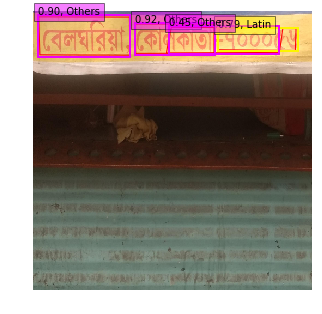

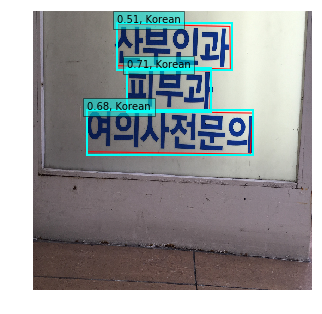

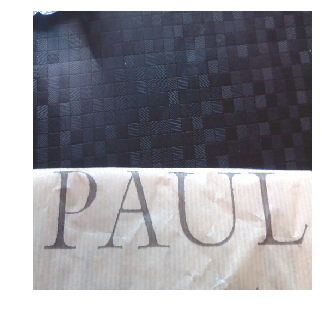

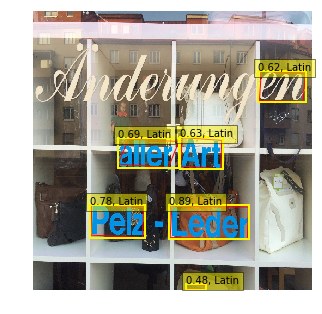

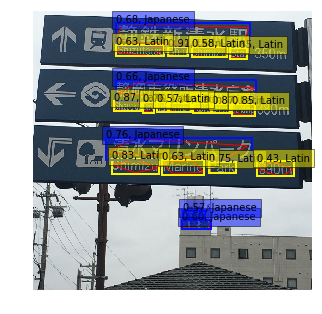

[ 866  115 1264 1748  425]


In [56]:
from utils.model import load_weights
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3
from utils.vis import plot_box


#Prediction
sample_batch_num = 5
idxs, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = 17) # github의 인수를 넣으면 너무 커서 멈춤
preds = modelJ.predict(inputs, batch_size=1, verbose=1)

for i in range(sample_batch_num):
    res = prior_util.decode(preds[i], confidence_threshold, fast_nms=False)
    bbox = res[:,0:4]
    quad = res[:,4:12]
    rbox = res[:,12:17]
#     print(res)
    #print(bbox)
    
    plt.figure(figsize=[sample_batch_num,16]) #수정 13
    plt.imshow(images[i])
    ax = plt.gca()
    for j in range(len(bbox)):
#         #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
#         plot_box(bbox[j]*512, box_format='xyxy', color='b')
        plot_box(np.reshape(quad[j],(-1,2))*512, box_format='polygon', color='r')
#         plot_box(rbox3_to_polygon(rbox[j])*512, box_format='polygon', color='g')
#         plt.plot(rbox[j,[0,2]]*512, rbox[j,[1,3]]*512, 'oc', markersize=4)
#     #prior_util.plot_gt()
    prior_util.plot_results(res, classes = ['Background', 'Latin', 'Chinese', 'Korean', 'Japanese', 'Others'])
    plt.axis('off')
    plt.show()
print(idxs)

In [58]:
gt_util_test.image_names[115]

'img_1101.jpg'

In [0]:
preds = modelJ.predict(inputs, batch_size=1, verbose=1) #수정 한상준10

    
#Grid Search
steps = np.arange(0.05, 0.8, 0.05)
fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
    pred_input = [np.concatenate([d[:,4:12], d[:,18].reshape(-1,1)], axis=1) for d in results] 
    precision, recall, fmes = prh(gt_input, pred_input)#수정 한상준9

    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))
    
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()




KeyboardInterrupt: ignored

5/5 [==============================] - 1s 138ms/step


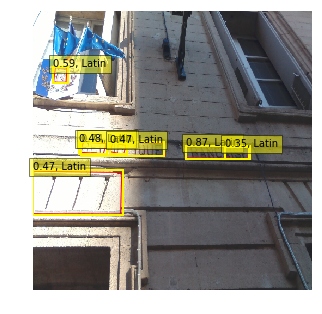

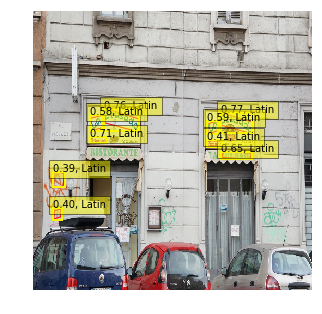

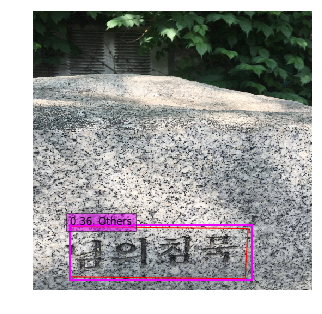

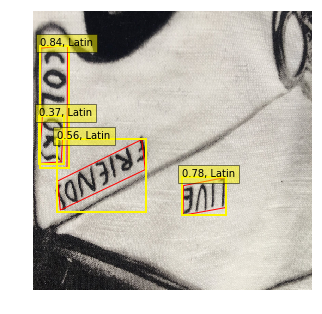

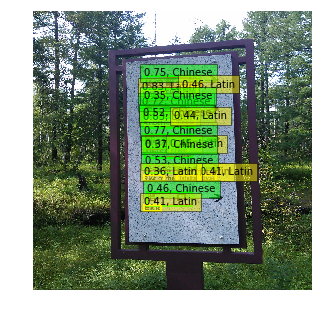

threshold 0.05 f-measure 0.18
threshold 0.10 f-measure 0.30
threshold 0.15 f-measure 0.38
threshold 0.20 f-measure 0.42
threshold 0.25 f-measure 0.49
threshold 0.30 f-measure 0.53
threshold 0.35 f-measure 0.54
threshold 0.40 f-measure 0.56
threshold 0.45 f-measure 0.49
threshold 0.50 f-measure 0.46
threshold 0.55 f-measure 0.45
threshold 0.60 f-measure 0.37
threshold 0.65 f-measure 0.33
threshold 0.70 f-measure 0.33
threshold 0.75 f-measure 0.26
0.4 0.5567010309278351


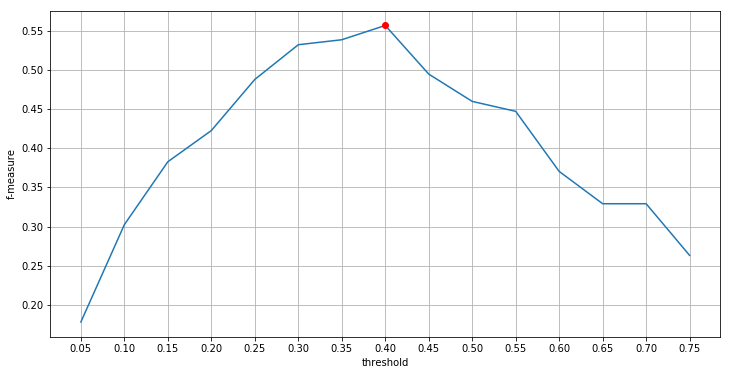

In [0]:
#test data visualize
from utils.model import load_weights
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3
from utils.vis import plot_box

with open('ICDAR2019_test.pkl', 'rb') as f:#validation/* 로 pkl (page5.5) #수정 박재현2
    gt_util_test = pickle.load(f)


#Model
K.clear_session()
modelJ = TBPP512(softmax=False)
weights_path = './checkpoints/weights.005.h5' # train을 통해 나온 weight의 최종본 넣기 #수정 박재현2
confidence_threshold = 0.4
plot_name = 'tbpp512fl_sythtext'

load_weights(modelJ, weights_path)
prior_util = PriorUtil(modelJ)

#Prediction
sample_batch_num = 5
_, inputs, images, data = gt_util_test.sample_random_batch(sample_batch_num, seed = None) # github의 인수를 넣으면 너무 커서 멈춤
preds = modelJ.predict(inputs, batch_size=1, verbose=1)

for i in range(sample_batch_num):
    res = prior_util.decode(preds[i], confidence_threshold, fast_nms=False)
    bbox = res[:,0:4]
    quad = res[:,4:12]
    rbox = res[:,12:17]
#     print(res)
    #print(bbox)
    
    plt.figure(figsize=[sample_batch_num,16]) #수정 13
    plt.imshow(images[i])
    ax = plt.gca()
    for j in range(len(bbox)):
#         #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
#         plot_box(bbox[j]*512, box_format='xyxy', color='b')
        plot_box(np.reshape(quad[j],(-1,2))*512, box_format='polygon', color='r')
#         plot_box(rbox3_to_polygon(rbox[j])*512, box_format='polygon', color='g')
#         plt.plot(rbox[j,[0,2]]*512, rbox[j,[1,3]]*512, 'oc', markersize=4)
#     #prior_util.plot_gt()
    prior_util.plot_results(res, classes = ['Background', 'Latin', 'Chinese', 'Korean', 'Japanese', 'Others'])
    plt.axis('off')
    plt.show()

    
#Grid Search
steps = np.arange(0.05, 0.8, 0.05)

fmes_grid = np.zeros((len(steps)))

for i, t in enumerate(steps):
    results = [prior_util.decode(p, t) for p in preds]
    gt_input = [np.concatenate([g[:,0:8], np.argmax(g[:,8:],axis=1).reshape(-1,1)], axis = 1) for g in data]
    pred_input = [np.concatenate([d[:,4:12], d[:,18:]], axis=1) for d in results] 
    precision, recall, fmes = prh(gt_input, pred_input)
#     TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in data], [d[:,4:12] for d in results])
#     recall = TP / (TP+FN)
#     precision = TP / (TP+FP)
#     fmes = fscore(precision, recall)
    fmes_grid[i] = fmes
    print('threshold %.2f f-measure %.2f' % (t, fmes))
    
max_idx = np.argmax(fmes_grid)
print(steps[max_idx], fmes_grid[max_idx])
plt.figure(figsize=[12,6])
plt.plot(steps, fmes_grid)
plt.plot(steps[max_idx], fmes_grid[max_idx], 'or')
plt.xticks(steps)
plt.grid()
plt.xlabel('threshold')
plt.ylabel('f-measure')
plt.show()



# #Precissions, Recall, F-measure
# batch_size = 32

# max_samples = gt_util_val.num_samples
# max_samples = batch_size * 8

# test_gt = []
# test_results = [] 

# for i in tqdm(range(int(np.ceil(max_samples/batch_size)))):
#     inputs, data = gt_util_val.sample_batch(batch_size, i)
#     preds = modelJ.predict(inputs, batch_size, verbose=0)
#     res = [prior_util.decode(p, confidence_threshold) for p in preds]
#     test_gt.extend(data)
#     test_results.extend(res)

# TP, FP, FN = evaluate_polygonal_results([g[:,0:8] for g in test_gt], [d[:,4:12] for d in test_results])
# recall = TP / (TP+FN)
# precision = TP / (TP+FP)
# fmes = fscore(precision, recall)

# print('samples train     %i' % (gt_util_train.num_samples))
# print('samples val       %i' % (gt_util_val.num_samples))

# print('samples           %i' % (max_samples))
# print('threshold         %0.3f' % (confidence_threshold))
# print('precision         %0.3f' % (precision))
# print('recall            %0.3f' % (recall))
# print('f-measure         %0.3f' % (fmes))

# trainable_count = int(np.sum([K.count_params(p) for p in set(modelJ.trainable_weights)]))
# non_trainable_count = int(np.sum([K.count_params(p) for p in set(modelJ.non_trainable_weights)]))

# print('trainable parameters     %10i' %(trainable_count))
# print('non-trainable parameters %10i' %(non_trainable_count))
# calc_memory_usage(modelJ)
